In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

import numpy as np                               # vectors and matrices
import pandas as pd
import datetime
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
from sklearn.metrics import mean_squared_error
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Populating the interactive namespace from numpy and matplotlib


In [3]:
VIX_File = 'CBOE_VIX.csv'
VIX = pd.read_csv(VIX_File, index_col = 0, parse_dates = [0])
VIX.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-26,28.440001,28.520000,27.270000,27.280001,27.280001,0
2022-10-27,27.510000,27.670000,26.940001,27.389999,27.389999,0
2022-10-28,27.430000,27.590000,25.750000,25.750000,25.750000,0
2022-10-31,26.910000,27.070000,25.840000,25.879999,25.879999,0
2022-11-01,25.959999,26.350000,25.660000,25.809999,25.809999,0
2022-11-02,26.040001,26.620001,25.389999,25.860001,25.860001,0
2022-11-03,25.980000,26.870001,25.100000,25.299999,25.299999,0
2022-11-04,25.629999,25.709999,24.000000,24.549999,24.549999,0
2022-11-07,25.670000,25.670000,24.340000,24.350000,24.350000,0


In [4]:
# Resample
VIX_week = VIX['Close'].resample('W-MON').mean()
train_index = int(len(VIX_week)*2/3)
VIX_train = VIX_week[0:train_index]
VIX_train.tail(1)

Date
2021-11-08    16.054
Freq: W-MON, Name: Close, dtype: float64

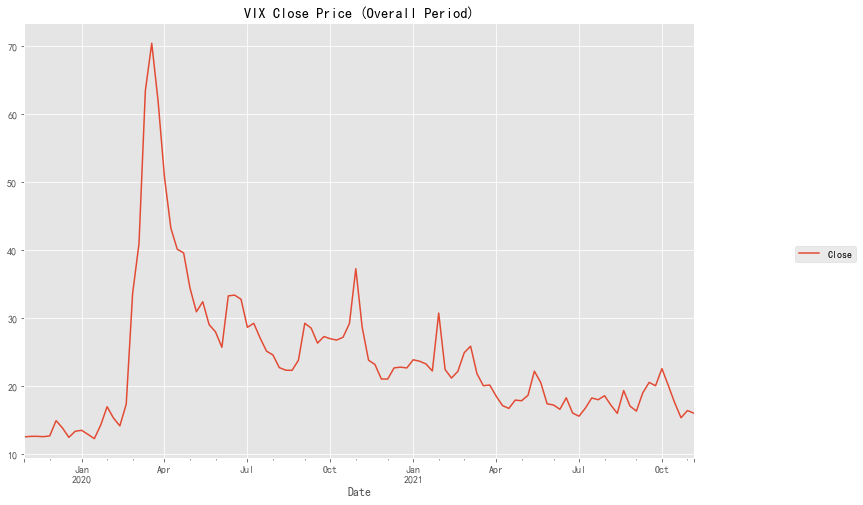

In [5]:
VIX_train.plot(figsize=(12, 8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title('VIX Close Price (Overall Period)')
sns.despine()
plt.show()

In [6]:
print(u'ADF Test result is:', ADF(VIX_train))

ADF Test result is: (-3.0614941233714226, 0.029537168054761732, 1, 104, {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}, 520.8733486411511)


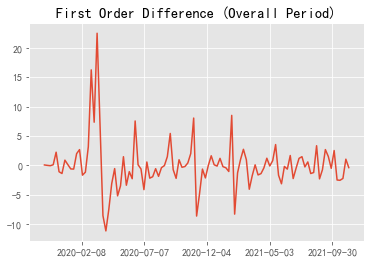

In [10]:
VIX_diff = VIX_train.diff()
VIX_diff = VIX_diff.dropna()

fig, ax = plt.subplots()
plt.plot(VIX_diff)
plt.title('First Order Difference (Overall Period)')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.show()

In [12]:
print(u'ADF Test result is:', ADF(VIX_diff))

ADF Test result is: (-7.277450453121134, 1.5312018601713603e-10, 0, 104, {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}, 522.8019849725896)


In [13]:
print(u'White Noise test result is：', acorr_ljungbox(VIX_diff, lags=1))

White Noise test result is： (array([10.81335052]), array([0.00100771]))


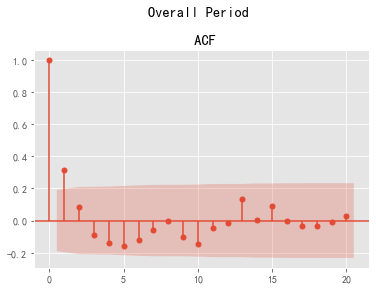

In [14]:
acf = plot_acf(VIX_diff, lags = 20)
plt.title('Overall Period \n \n ACF')
acf.show()

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

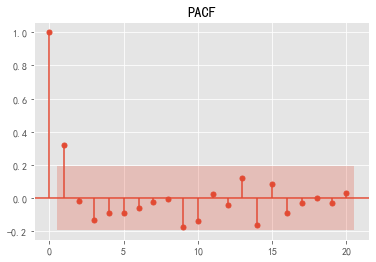

In [15]:
pacf = plot_pacf(VIX_diff, lags = 20)
plt.title('PACF')
pacf.show

In [18]:
arma_mod20 = sm.tsa.ARIMA(VIX["Close"],(1,1,0)).fit()
arma_mod30 = sm.tsa.ARIMA(VIX["Close"],(0,1,1)).fit()
arma_mod40 = sm.tsa.ARIMA(VIX["Close"],(1,1,1)).fit()
values = [[arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic],[arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic],[arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic]]
df = pd.DataFrame(values,index=["AR(1,1,0)","MA(0,1,1)","ARMA(1,1,1)"],columns=["AIC","BIC","hqic"])
df

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

,AIC,BIC,hqic
"AR(1,1,0)",3555.398358,3569.298313,3560.750989
"MA(0,1,1)",3563.749466,3577.649421,3569.102097
"ARMA(1,1,1)",3556.387553,3574.920827,3563.524395


In [20]:
model_1 = ARIMA(VIX_train, order = (1, 1, 0), freq = 'W-MON')
result = model_1.fit()

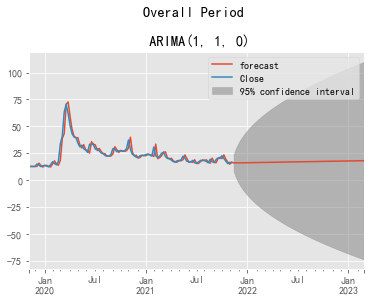

In [21]:
result.plot_predict(start = 1, end = 173)
plt.title("Overall Period \n \n ARIMA(1, 1, 0)")
plt.show()

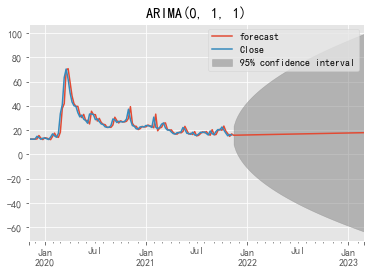

In [22]:
model_011 = ARIMA(VIX_train, order = (0, 1, 1), freq = 'W-MON')
result_011 = model_011.fit()
result_011.plot_predict(start = 1, end = 173)
plt.title("ARIMA(0, 1, 1)")
plt.show()

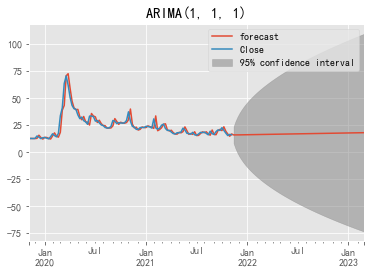

In [23]:
model_111 = ARIMA(VIX_train, order = (1, 1, 1), freq = 'W-MON')
result_111 = model_111.fit()
result_111.plot_predict(start = 1, end = 173)
plt.title("ARIMA(1, 1, 1)")
plt.show()

In [24]:
print("Overall Period")
print(result.summary())

Overall Period
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  105
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -292.728
Method:                       css-mle   S.D. of innovations              3.929
Date:                Wed, 09 Nov 2022   AIC                            591.456
Time:                        16:18:49   BIC                            599.418
Sample:                    11-11-2019   HQIC                           594.682
                         - 11-08-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0316      0.556      0.057      0.955      -1.058       1.122
ar.L1.D.Close     0.3134      0.092      3.405      0.001       0.133       0.494
                         

Text(0.5, 1.0, 'Overall Period')

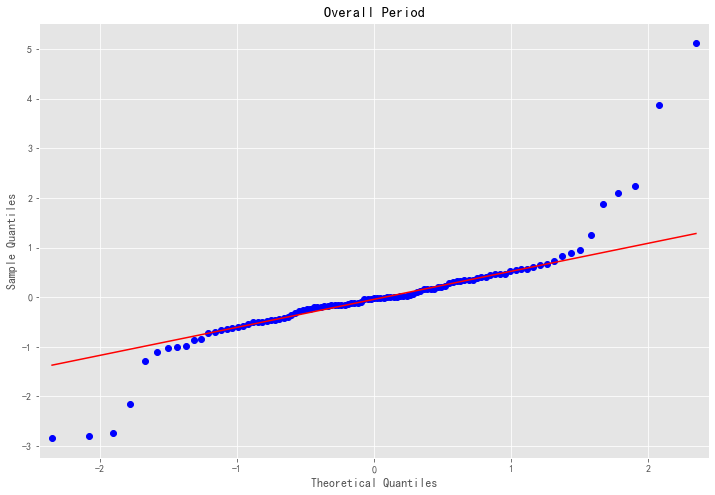

In [25]:
resid = result.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.title("Overall Period")

In [26]:
print(acorr_ljungbox(resid)[1])

[0.93461225 0.95872493 0.79609779 0.76233061 0.69970621 0.73121212
 0.81492807 0.85226588 0.85424986 0.76460743 0.83216095 0.86703265
 0.6752467  0.69059865 0.63323491 0.69559947 0.74971747 0.79769385
 0.84335106 0.85171807 0.8424523  0.84357803 0.85139465 0.85742201
 0.87798167 0.90377856 0.92010878 0.93964212 0.9542669  0.9502647
 0.95902165 0.95708409 0.77638723 0.43210003 0.44509456 0.44420948
 0.48710537 0.50310459 0.53363431 0.57825259]


In [55]:
pred = result.predict('2021-11-09', "2024", dynamic=True, typ='levels')

In [61]:
pred_val = pred['2021-12-27'] + ((pred['2022-01-03'] - pred['2021-12-27'])/7*5)
print(pred_val)

16.111134889729875


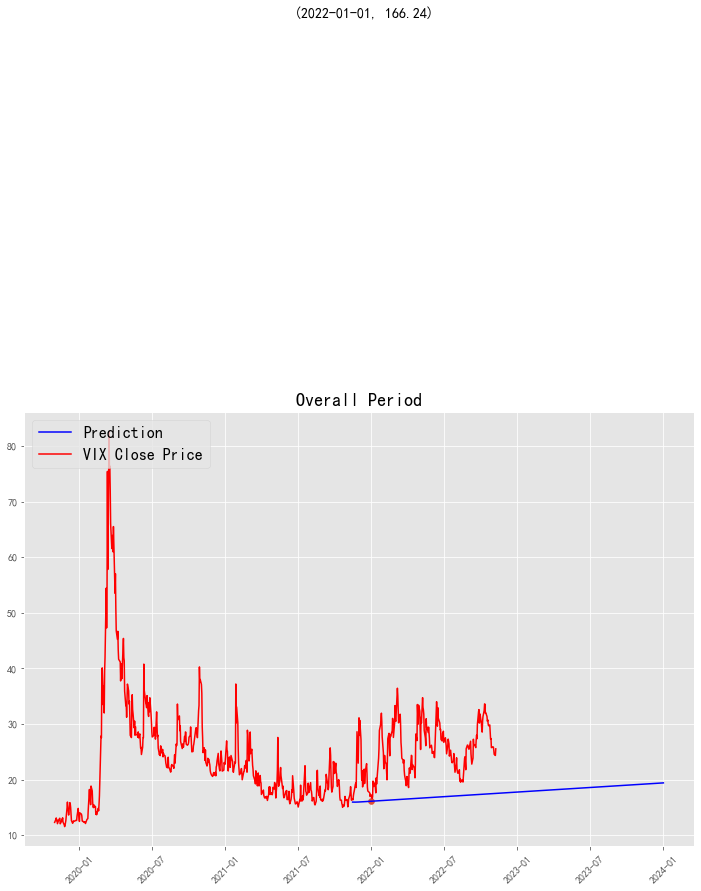

In [57]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
plt.plot(pred, "-b", label="Prediction")
plt.plot(VIX.Close, "-r", label="VIX Close Price")
text(18800, 157, "(2022-01-01, 166.24)", fontsize=14)
scatter(['2022-01-01'],[pred_val])
plt.legend(loc="upper left", fontsize=16)
plt.title("Overall Period", fontsize=18)
plt.show()

In [53]:
test_index = int(len(VIX_week)*2/3)
VIX_test = VIX_week[test_index:]
test_pred = pred[0:int(len(VIX_week)*1/3+1)]
print("MSE: ", mean_squared_error(VIX_test, test_pred))

ValueError: Found input variables with inconsistent numbers of samples: [53, 54]